In [450]:
# ============================================================
#  Imports – Analyse exploratoire des données (EDA)
# ============================================================
# --- Gestion des chemins et du système
import os
from pathlib import Path
# --- Traitement et manipulation des données
import numpy as np
import pandas as pd
# --- Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# --- Prétraitement et réduction de dimension
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# --- Analyses statistiques
from scipy.stats import chi2_contingency   # Test du χ² pour l’indépendance entre variables catégorielles
from sklearn.feature_selection import f_classif  # ANOVA F-test pour mesurer la dépendance entre variable et cible

In [452]:
# ============================================================
#  Configuration du répertoire de travail
# ============================================================
# Définition du chemin vers le dossier contenant les données du data challenge.
# On utilise 'os.chdir()' pour définir le répertoire courant afin de faciliter
# les lectures de fichiers sans avoir à préciser de chemins absolus à chaque fois.

path = r"C:\Users\yanis\OneDrive\Bureau\M2MIA\SP\DATA_CHALLENGE\CLASSIFICATION\booking-cancel-prediction"

# Vérifie que le chemin existe avant de le définir comme répertoire courant
if os.path.exists(path):
    os.chdir(path)
    print(f"Répertoire courant défini sur : {os.getcwd()}")
else:
    raise FileNotFoundError(f"Le chemin spécifié est introuvable : {path}")

# Liste les fichiers présents dans le dossier pour vérifier la structure
print("\n Contenu du répertoire :")
for file in os.listdir():
    print(" -", file)

['naive_submission.csv',
 'submission1_kernel_rbf_svc_fast.csv',
 'submission1_random_forest.csv',
 'submission1_reglogmult.csv',
 'test_data.csv',
 'train_data.csv']

In [409]:
# ============================================================
#  Chargement du jeu de données d’entraînement
# ============================================================
# Lecture du fichier CSV contenant les observations étiquetées.
# On supprime les colonnes non informatives :
#  - 'row_id' : simple identifiant de ligne sans valeur explicative.
#  - 'Unnamed: 0' : colonne d’index parfois générée automatiquement à l’enregistrement.

data = pd.read_csv("train_data.csv")
data = data.drop(columns=["row_id", "Unnamed: 0"], errors="ignore")

# Dimensions du jeu de données
n_obs, n_features = data.shape
print(f" Jeu de données chargé : {n_obs} observations, {n_features} variables explicatives (hors cible).")

# Aperçu rapide des premières lignes
display(data.head())


 le dataset contient n = 68898 observations et d = 28 covariables


In [410]:
# ============================================================
#  Aperçu du jeu de données
# ============================================================

print(" Aperçu du jeu de données :")
display(data.head())

# Dimensions du DataFrame 
print(f"\n Dimensions : {data.shape[0]} observations × {data.shape[1]} variables")


Aperçu du jeu de données :


,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,reserved_room_type,assigned_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status
0,City Hotel,47,2016,March,13,20,2,2,2,0.0,...,A,D,0,No Deposit,0,Transient,85.00,0,0,2
1,Resort Hotel,221,2017,April,18,30,2,5,2,0.0,...,A,A,0,No Deposit,0,Transient-Party,71.43,0,0,1
2,City Hotel,11,2016,February,6,1,2,5,2,0.0,...,A,A,0,No Deposit,0,Transient,79.00,0,0,1
3,Resort Hotel,88,2015,November,48,28,2,4,2,0.0,...,A,A,0,No Deposit,0,Transient,32.40,0,0,1
4,Resort Hotel,250,2017,August,33,13,2,2,2,0.0,...,A,A,1,No Deposit,0,Transient,106.85,0,1,0


In [413]:
# ============================================================
# Conversion des variables catégorielles codées numériquement
# ============================================================
# La variable 'reservation_status' est convertie en facteur (type 'category')
# en associant à chaque entier sa modalité correspondante.
# De même, 'is_repeated_guest' est transformée en variable catégorielle
# pour faciliter l’interprétation et les visualisations.

data["reservation_status"] = data["reservation_status"].map({
    0: "Check-Out",
    1: "Canceled",
    2: "No-Show"
}).astype("category")

data["is_repeated_guest"] = data["is_repeated_guest"].map({
    0: "Yes",
    1: "No"
}).astype("category")


In [415]:
# Vérification
print(data['reservation_status'].value_counts())
print(data['reservation_status'].dtype)

reservation_status
Check-Out    43365
Canceled     24849
No-Show        684
Name: count, dtype: int64
category


In [417]:
# Identification des variables explicatives numériques et catégorielles
numeric_cols = data.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = data.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print(f"Nb features: {data.shape[1]} | num: {len(numeric_cols)} | cat: {len(categorical_cols)}")

Nb features: 28 | num: 16 | cat: 12


In [419]:
print(numeric_cols)

['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']


In [421]:
print(categorical_cols)

['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status']


In [423]:
# ============================================================
# Préambule : configuration graphique et préparation du dossier de sortie
# ============================================================
# Configuration du style des graphiques pour une meilleure lisibilité.
# Création automatique des répertoires de sauvegarde pour les figures
# et les tables LaTeX si ceux-ci n'existent pas déjà.

sns.set(context="notebook", style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 5)

Path("figs").m


In [425]:
# ============================================================
#  Résumé général
# ============================================================
summary = pd.DataFrame({
    "Type": data.dtypes,
    "Valeurs uniques": data.nunique(),
    "Valeurs manquantes (%)": (data.isna().mean() * 100).round(2)
})
summary.to_latex("latex_tables/summary.tex", caption="Résumé des variables du jeu de données", label="tab:summary")
display(summary)

,Type,Valeurs uniques,Valeurs manquantes (%)
hotel,object,2,0.0
lead_time,int64,474,0.0
arrival_date_year,int64,3,0.0
arrival_date_month,object,12,0.0
arrival_date_week_number,int64,53,0.0
arrival_date_day_of_month,int64,31,0.0
stays_in_weekend_nights,int64,15,0.0
stays_in_week_nights,int64,31,0.0
adults,int64,11,0.0
children,float64,5,0.0


In [427]:
# ============================================================
#  Distribution de la cible
# ============================================================
cls_counts = data[target].value_counts()
cls_ratio = (cls_counts / len(data) * 100).round(2)
class_summary = pd.DataFrame({"Classe": cls_counts.index, "Effectif": cls_counts.values, "Proportion (%)": cls_ratio.values})
class_summary.to_latex("latex_tables/class_distribution.tex", caption="Répartition des classes de la variable cible", label="tab:class_dist", index=False)

#  on insère le centrage manuellement dans le fichier généré
with open("latex_tables/class_distribution.tex", "r", encoding="utf8") as f:
    content = f.read()

# Si \centering n'existe pas, on l’ajoute juste après \begin{table}
if "\\centering" not in content:
    content = content.replace("\\begin{table}", "\\begin{table}\n\\centering", 1)

with open("latex_tables/class_distribution.tex", "w", encoding="utf8") as f:
    f.write(content)

ax = sns.countplot(x=target, data=data, order=cls_counts.index)
ax.set_title("Répartition de la variable cible")
plt.tight_layout()
plt.savefig("figs/class_distribution.png")
plt.close()

In [428]:
# ============================================================
#  Statistiques descriptives des variables numériques
# ============================================================
desc = data[numeric_cols].describe().T
desc.to_latex("latex_tables/numeric_descriptive.tex", caption="Statistiques descriptives des variables numériques", label="tab:num_desc", float_format="%.2f")

#  on insère le centrage manuellement dans le fichier généré
with open("latex_tables/numeric_descriptive.tex", "r", encoding="utf8") as f:
    content = f.read()

# Si \centering n'existe pas, on l’ajoute juste après \begin{table}
if "\\centering" not in content:
    content = content.replace("\\begin{table}", "\\begin{table}\n\\centering", 1)

with open("latex_tables/numeric_descriptive.tex", "w", encoding="utf8") as f:
    f.write(content)


display(desc)

,count,mean,std,min,25%,50%,75%,max
lead_time,68898.0,104.201878,106.970199,0.0,18.0,69.0,160.0,709.0
arrival_date_year,68898.0,2016.159424,0.705899,2015.0,2016.0,2016.0,2017.0,2017.0
arrival_date_week_number,68898.0,27.113124,13.549977,1.0,16.0,27.0,38.0,53.0
arrival_date_day_of_month,68898.0,15.798572,8.777819,1.0,8.0,16.0,23.0,31.0
stays_in_weekend_nights,68898.0,0.930796,0.996605,0.0,0.0,1.0,2.0,16.0
stays_in_week_nights,68898.0,2.496981,1.895463,0.0,1.0,2.0,3.0,41.0
adults,68898.0,1.856759,0.553997,0.0,2.0,2.0,2.0,50.0
children,68898.0,0.105010,0.401118,0.0,0.0,0.0,0.0,10.0
babies,68898.0,0.008055,0.102690,0.0,0.0,0.0,0.0,10.0
previous_cancellations,68898.0,0.090525,0.902800,0.0,0.0,0.0,0.0,26.0


In [429]:
# ============================================================
#  Corrélations numériques
# ============================================================

# Calcul de la matrice de corrélation
corr = data[numeric_cols].corr(method="spearman")

# Masque du triangle supérieur (pour alléger la lecture)
mask = np.triu(np.ones_like(corr, dtype=bool))

# Style global
sns.set_theme(style="dark", font_scale=2)
plt.figure(figsize=(1.2*len(numeric_cols), 1.1*len(numeric_cols)))

# Palette plus contrastée 
ax = sns.heatmap(
    corr,
    mask=mask,
    cmap=sns.diverging_palette(240, 10, as_cmap=True, s=90, l=40),
    vmin=-1, vmax=1,
    center=0,
    square=True,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 15, "fontweight": "bold"},
    linewidths=2,
    linecolor="white",
    cbar_kws={"shrink": 0.8, "label": "Coefficient de corrélation"}
)

# Titre principal en gras
ax.set_title("Matrice de corrélation", fontsize=23, fontweight="bold", pad=20)

# Noms de variables 
ax.set_xticklabels(
    [t.get_text() for t in ax.get_xticklabels()],
    rotation=45, ha="right",
    fontsize=20, fontweight="bold"
)
ax.set_yticklabels(
    [t.get_text() for t in ax.get_yticklabels()],
    rotation=0,
    fontsize=20, fontweight="bold"
)

# Optimisation visuelle
plt.tight_layout()
plt.savefig("figs/corr_matrix.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.close()

In [432]:
# ============================================================
#  Relations variable–cible
# ============================================================

# ANOVA pour les numériques
X_num = data[numeric_cols].fillna(data[numeric_cols].median())
y_enc = data[target].cat.codes
f_vals, p_vals = f_classif(X_num, y_enc)
anova_tbl = pd.DataFrame({"Variable": numeric_cols, "F-Score": f_vals, "p-value": p_vals}).sort_values("F-Score", ascending=False)
anova_tbl.to_latex("latex_tables/anova_scores.tex", caption="Scores ANOVA entre les variables numériques et la cible", label="tab:anova", float_format="%.2f", index=False)

#  on insère le centrage manuellement dans le fichier généré
with open("latex_tables/anova_scores.tex", "r", encoding="utf8") as f:
    content = f.read()

# Si \centering n'existe pas, on l’ajoute juste après \begin{table}
if "\\centering" not in content:
    content = content.replace("\\begin{table}", "\\begin{table}\n\\centering", 1)

with open("latex_tables/anova_scores.tex", "w", encoding="utf8") as f:
    f.write(content)



display(anova_tbl)

,Variable,F-Score,p-value
0,lead_time,3486.821307,0.000000e+00
15,total_of_special_requests,2080.193803,0.000000e+00
14,required_car_parking_spaces,1361.562176,0.000000e+00
11,booking_changes,739.041163,2.710261e-318
9,previous_cancellations,418.070919,3.365555e-181
6,adults,189.529433,8.203970e-83
12,days_in_waiting_list,117.284122,1.414711e-51
10,previous_bookings_not_canceled,104.941541,3.117082e-46
13,adr,86.533130,2.925920e-38
8,babies,37.661677,4.494447e-17


In [433]:
# Cramér’s V pour les catégorielles
def cramers_v_bias_corrected(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix, correction=False)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    rcorr = r - (r-1)**2/(n-1)
    kcorr = k - (k-1)**2/(n-1)
    return np.sqrt(phi2corr / max((kcorr-1), (rcorr-1)))

assoc = []
for c in categorical_cols:
    if data[c].nunique() <= 30:  # limite cardinalité
        cm = pd.crosstab(data[c], data[target])
        v = cramers_v_bias_corrected(cm)
        assoc.append((c, v))
assoc_df = pd.DataFrame(assoc, columns=["Variable", "CramersV"]).sort_values("CramersV", ascending=False)
assoc_df.to_latex("latex_tables/cramersv.tex", caption="Association (Cramér's V) entre les variables catégorielles et la cible", label="tab:cramersv", float_format="%.3f", index=False)

#  on insère le centrage manuellement dans le fichier généré
with open("latex_tables/cramersv.tex", "r", encoding="utf8") as f:
    content = f.read()

# Si \centering n'existe pas, on l’ajoute juste après \begin{table}
if "\\centering" not in content:
    content = content.replace("\\begin{table}", "\\begin{table}\n\\centering", 1)

with open("latex_tables/cramersv.tex", "w", encoding="utf8") as f:
    f.write(content)


display(assoc_df)

,Variable,CramersV
10,reservation_status,1.000000
8,deposit_type,0.347188
3,market_segment,0.113125
0,hotel,0.098560
4,distribution_channel,0.091314
9,customer_type,0.082117
7,assigned_room_type,0.062564
5,is_repeated_guest,0.061152
1,arrival_date_month,0.028824
2,meal,0.027105


In [434]:
# ============================================================
#  ACP sur les variables numériques — projection, éboulis, cercle des corrélations
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.patches import Circle

if len(numeric_cols) > 2:
    # ---------- Style général : plutôt foncé, contrasté ----------
    sns.set_theme(style="darkgrid", context="notebook")
    plt.rcParams.update({
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "savefig.facecolor": "white",
        "axes.titlesize": 16,
        "axes.titleweight": "bold",
        "axes.labelsize": 12,
        "legend.title_fontsize": 11,
        "legend.fontsize": 10
    })

    # ---------- Données standardisées ----------
    X_num = data[numeric_cols].copy()
    X_num = X_num.fillna(X_num.median())
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X_num)

    # ---------- PCA  ----------
    ncomp = min(10, Xs.shape[1])
    pca_full = PCA(n_components=ncomp, random_state=42)
    Z_full = pca_full.fit_transform(Xs)

    # ----------  Projection individus (PC1 vs PC2) ----------
    # (on re-calcule une PCA à 2D juste pour clarté, sinon on peut réutiliser pca_full)
    pca2 = PCA(n_components=2, random_state=42)
    Z = pca2.fit_transform(Xs)

    plt.figure(figsize=(8.5, 6))
    palette = sns.color_palette("husl", n_colors=data[target].nunique())
    sns.scatterplot(
        x=Z[:, 0], y=Z[:, 1], hue=data[target],
        s=20, alpha=0.7, edgecolor="none", palette=palette
    )
    plt.title("ACP — projection des individus (PC1 vs PC2)", pad=10, fontweight="bold")
    plt.xlabel(f"PC1 ({pca2.explained_variance_ratio_[0]*100:.1f} %)")
    plt.ylabel(f"PC2 ({pca2.explained_variance_ratio_[1]*100:.1f} %)")
    plt.tight_layout()
    plt.savefig("figs/pca_projection.png")
    plt.close()

   # ----------  Éboulis des valeurs propres (scree plot) ----------
    evr = pca_full.explained_variance_ratio_ * 100

    x = np.arange(1, len(evr) + 1)  # mêmes abscisses pour barres et courbe

    fig, ax = plt.subplots(figsize=(8.5, 5.8))
    bars = ax.bar(x, evr, color=sns.color_palette("rocket", n_colors=len(evr)), width=0.8, align="center")


    #  petites étiquettes sur chaque barre
    for i, v in enumerate(evr):
        ax.text(x[i], v + 0.6, f"{v:.1f}", ha="center", va="bottom", fontsize=9, fontweight="bold")

    ax.set_xticks(x)
    ax.set_xlabel("Composante principale")
    ax.set_ylabel("Variance expliquée (%)")
    ax.set_ylim(0, max(12, evr.max() + 8))
    ax.set_title("ACP — éboulis des valeurs propres", pad=10, fontweight="bold")
    ax.legend()
    plt.tight_layout()
    plt.savefig("figs/pca_scree.png", dpi=300, bbox_inches="tight", facecolor="white")
    plt.close(fig)

    # ---------- Cercle des corrélations (variables) ----------
    # Pour données standardisées, corr(var, PCj) = loading(var, PCj) = V * sqrt(λ)
    # où V = pca.components_.T  (variables × composantes)
    # On utilise ici pca2 (2 composantes) pour cercle PC1/PC2.
    loadings = pca2.components_.T * np.sqrt(pca2.explained_variance_)
    # loadings.shape = (n_features, 2)
    xs, ys = loadings[:, 0], loadings[:, 1]

    # Sélection des variables à annoter 
    # -> on annote les 20 plus contributives en norme 2D dans (PC1, PC2)
    norms = np.sqrt(xs**2 + ys**2)
    top_k = min(20, len(numeric_cols))
    top_idx = np.argsort(norms)[::-1][:top_k]

    fig, ax = plt.subplots(figsize=(7.8, 7.8))
    ax.set_aspect('equal')

    # Cercle unité
    circle = Circle((0, 0), 1, facecolor="none", edgecolor="gray", lw=1.5, alpha=0.9)
    ax.add_patch(circle)
    ax.axhline(0, color="gray", lw=1)
    ax.axvline(0, color="gray", lw=1)

    # Flèches (toutes), mais annotation seulement pour top_k
    base_color = sns.color_palette("dark:#66c2a5", as_cmap=False)[0]
    for i in range(len(numeric_cols)):
        ax.arrow(0, 0, xs[i], ys[i],
                 head_width=0.025, head_length=0.04,
                 fc=base_color, ec=base_color, alpha=0.9, length_includes_head=True, lw=1.2)

    # Annotations des plus importantes
    for i in top_idx:
        ax.text(xs[i]*1.08, ys[i]*1.08, numeric_cols[i],
                ha="center", va="center", fontsize=11, fontweight="bold", color="#222222",
                bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.7))

    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlabel(f"PC1 ({pca2.explained_variance_ratio_[0]*100:.1f} %)")
    ax.set_ylabel(f"PC2 ({pca2.explained_variance_ratio_[1]*100:.1f} %)")
    ax.set_title("ACP — cercle des corrélations (espace des variables)", pad=12, fontweight="bold")
    plt.tight_layout()
    plt.savefig("figs/pca_correlation_circle.png")
    plt.close(fig)

    # ---------- Table LaTeX de variance expliquée (k composantes) ----------
    explained_tbl = pd.DataFrame({
        "Composante": [f"PC{i}" for i in range(1, ncomp+1)],
        "Variance expliquée (%)": evr,
        "Variance cumulée (%)": cum
    })
    explained_tbl.to_latex(
        "latex_tables/pca_variance.tex",
        caption="Variance expliquée et cumulée par les composantes principales",
        label="tab:pca_variance",
        index=False, float_format="%.2f"
    )

    #  aperçu
    display(explained_tbl.head(10))


C:\Users\yanis\AppData\Local\Temp\ipykernel_52836\1483703802.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


,Composante,Variance expliquée (%),Variance cumulée (%)
0,PC1,11.266013,11.266013
1,PC2,10.096394,21.362407
2,PC3,8.919670,30.282077
3,PC4,7.830195,38.112272
4,PC5,6.930518,45.042790
5,PC6,6.703465,51.746255
6,PC7,6.398317,58.144572
7,PC8,6.170320,64.314892
8,PC9,5.944148,70.259040
9,PC10,5.511297,75.770337


In [435]:


with open("latex_tables/eda_summary.tex", "w", encoding="utf8") as f:
    f.write(summary_text)

print("\n Export LaTeX terminé :")
print("→ Tables : dossier 'latex_tables/'")
print("→ Figures : dossier 'figs/'")


 Export LaTeX terminé :
→ Tables : dossier 'latex_tables/'
→ Figures : dossier 'figs/'


C:\Users\yanis\AppData\Local\Temp\ipykernel_52836\2366491690.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\yanis\AppData\Local\Temp\ipykernel_52836\2366491690.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\yanis\AppData\Local\Temp\ipykernel_52836\2366491690.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\yanis\AppData\Local\Temp\ipykernel_52836\2366491690.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `h

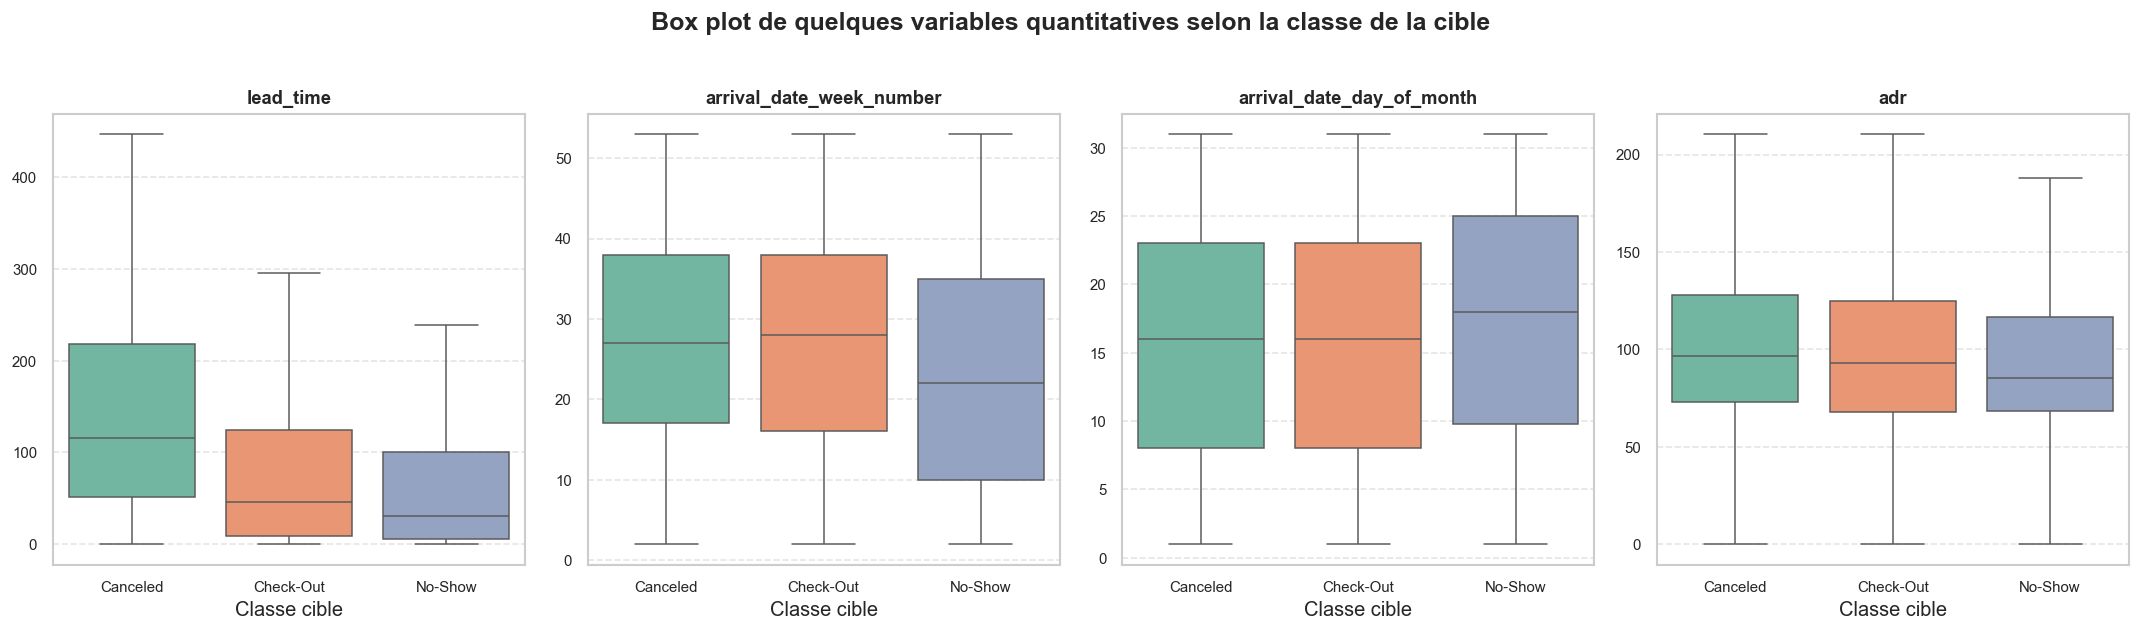

In [454]:
# ============================================================
#  Boxplots sélectionnés des variables quantitatives par classe cible
# ============================================================

sns.set_theme(style="whitegrid", context="notebook")

plt.rcParams.update({
    "figure.dpi": 120, "savefig.dpi": 300,
    "axes.titlesize": 12, "axes.titleweight": "bold",
    "xtick.labelsize": 9, "ytick.labelsize": 9
})

target = "reservation_status"
numeric_to_plot = ["lead_time", "arrival_date_week_number", "arrival_date_day_of_month", "adr"]

# --- 1) Copie pour l'affichage + clipping percentile par variable
CLIP_P = (1, 99)  # clip visuel (1er et 99e percentiles)
data_plot = data.copy()
clip_bounds = {}
for col in numeric_to_plot:
    lo, hi = np.nanpercentile(data_plot[col], CLIP_P)
    clip_bounds[col] = (lo, hi)
    data_plot[col] = data_plot[col].clip(lower=lo, upper=hi)

# --- 2) Grille 1x4 (4 boxplots côte à côte)
nrows, ncols = 1, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 5))
axes = axes.flatten()
palette = sns.color_palette("Set2", n_colors=data[target].nunique())

for i, col in enumerate(numeric_to_plot):
    ax = axes[i]
    sns.boxplot(
        data=data_plot,
        x=target,
        y=col,
        palette=palette,
        linewidth=0.9,
        fliersize=0,
        showfliers=False,
        ax=ax
    )
    ax.set_title(col, fontsize=11, fontweight="bold")
    ax.set_xlabel("Classe cible")
    ax.set_ylabel("")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

# Titre global
plt.suptitle(
    f"Box plot de quelques variables quantitatives selon la classe de la cible",
    fontsize=15, fontweight="bold", y=1.05
)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.savefig("boxplots_top4.png", bbox_inches="tight", facecolor="white")
plt.show()

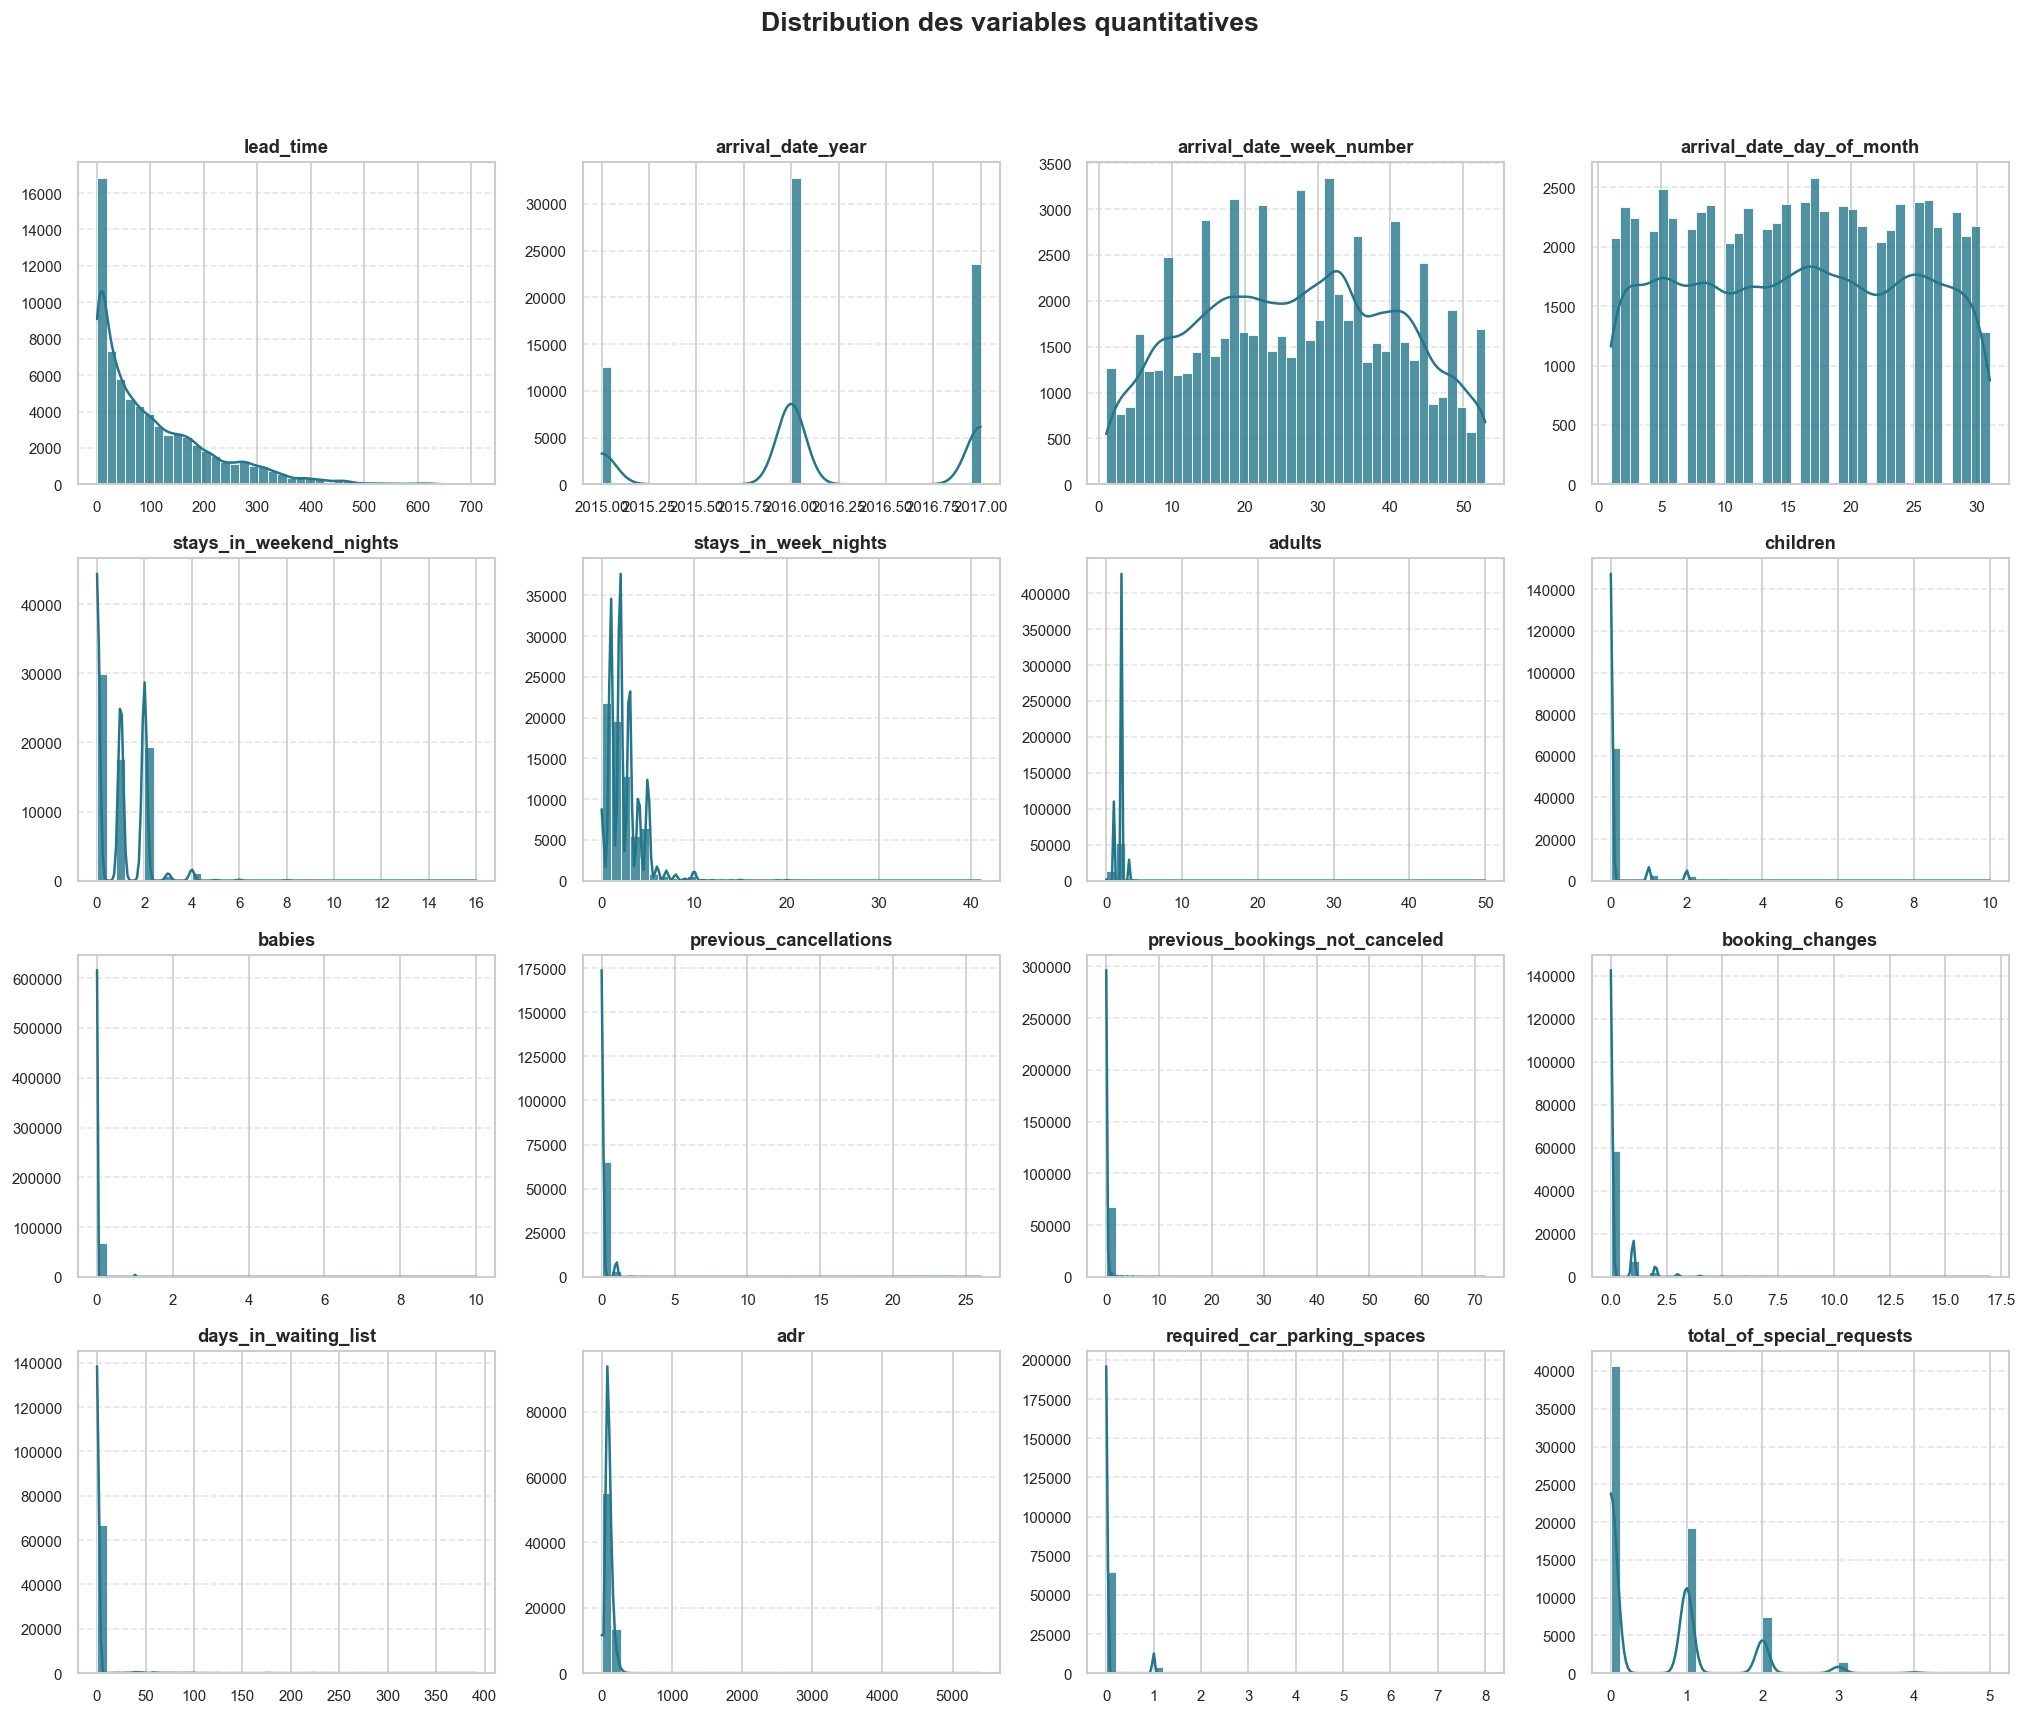

In [460]:
# ============================================================
#  Histogrammes des variables quantitatives
# ============================================================

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams.update({
    "figure.dpi": 120, "savefig.dpi": 300,
    "axes.titlesize": 12, "axes.titleweight": "bold",
    "xtick.labelsize": 9, "ytick.labelsize": 9,
    "axes.labelsize": 10,
})

# Liste des variables quantitatives (16 max)
numeric_to_plot = numeric_cols

# Grille 4x4
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(17, 14))
axes = axes.flatten()

for i, col in enumerate(numeric_to_plot):
    ax = axes[i]
    
    # Histogramme avec KDE (lissage de densité)
    sns.histplot(
        data=data,
        x=col,
        bins=40,
        kde=True,
        color=sns.color_palette("crest", as_cmap=True)(0.6),
        line_kws={"linewidth": 1.5},
        edgecolor=None,
        alpha=0.8,
        ax=ax
    )
    ax.set_title(col, fontsize=11, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.grid(axis="y", linestyle="--", alpha=0.5)


plt.suptitle("Distribution des variables quantitatives", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig("histo_covariables_num.png", bbox_inches="tight", facecolor="white")
plt.show()


C:\Users\yanis\AppData\Local\Temp\ipykernel_52836\703190739.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\yanis\AppData\Local\Temp\ipykernel_52836\703190739.py:26: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.countplot(
C:\Users\yanis\AppData\Local\Temp\ipykernel_52836\703190739.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\yanis\AppData\Local\Temp\ipykernel_52836\703190739.py:26: UserWarning: 
The palette list has fewer values (8) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(
C:\Users\yanis\AppData\Local\Temp\ipykernel_52836\703190739.py:26: FutureWar

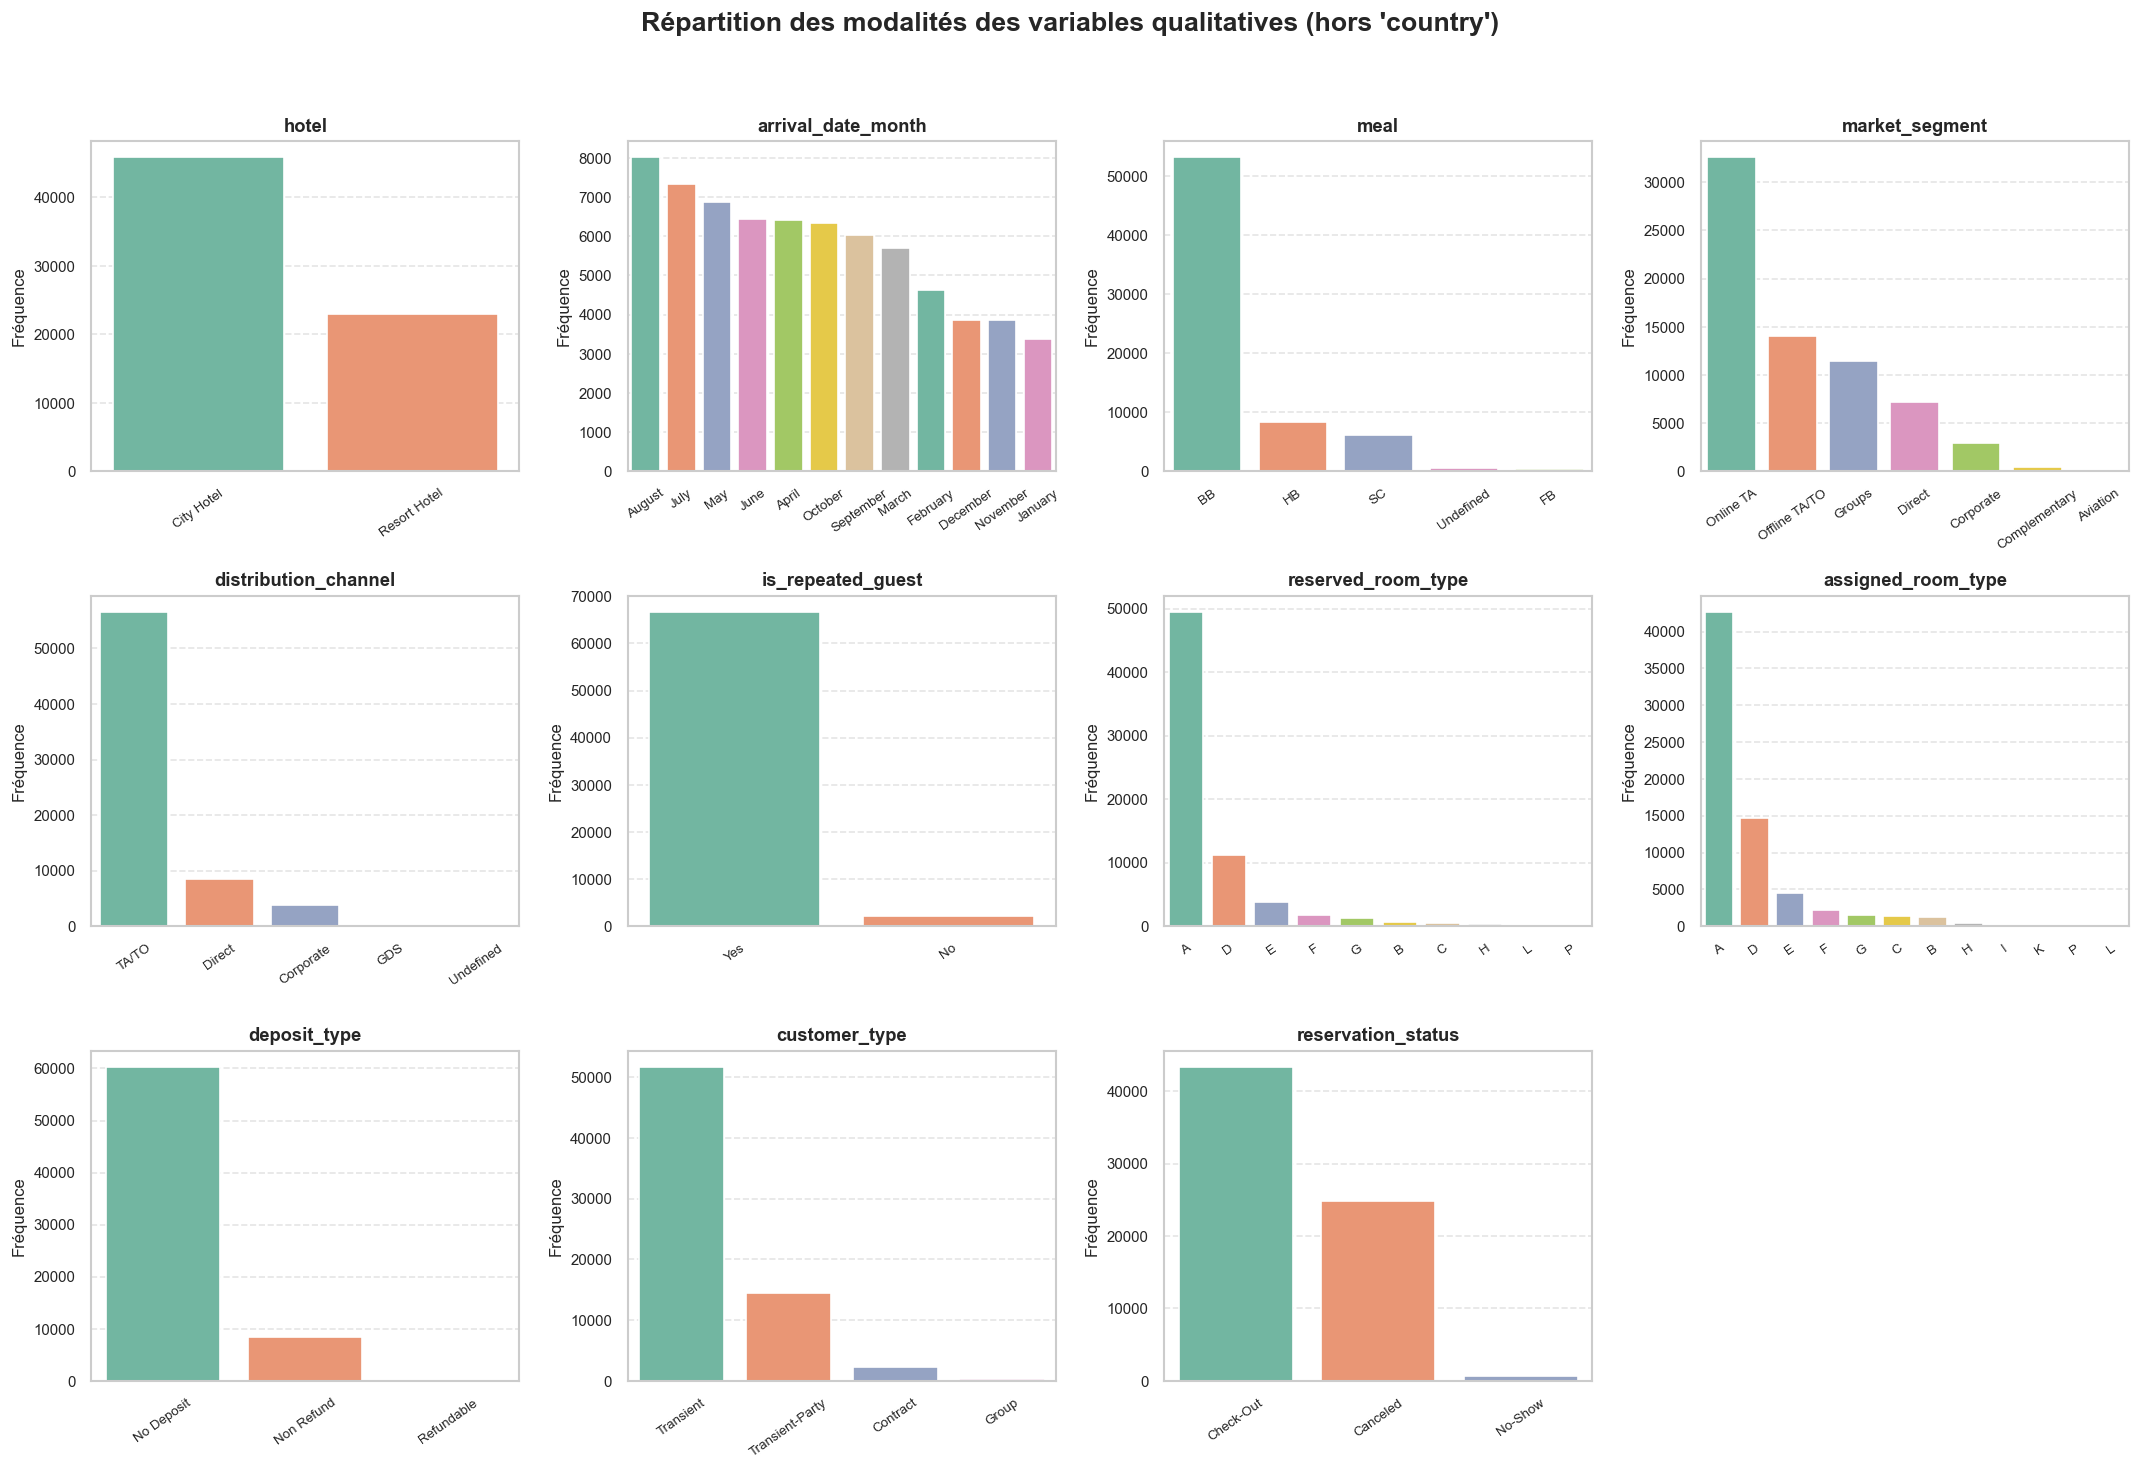

In [466]:
# ============================================================
#  Répartition des variables qualitatives 
# ============================================================

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams.update({
    "figure.dpi": 120, "savefig.dpi": 300,
    "axes.titlesize": 12, "axes.titleweight": "bold",
    "xtick.labelsize": 8, "ytick.labelsize": 9,
    "axes.labelsize": 10,
})

# Sélectionner les 12 variables qualitatives sans "country"
categorical_to_plot = [col for col in categorical_cols if col != "country"][:12]

# Grille 3x4
nrows, ncols = 3, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 12))
axes = axes.flatten()

palette = sns.color_palette("Set2")

for i, col in enumerate(categorical_to_plot):
    ax = axes[i]
    order = data[col].value_counts().index  # tri par fréquence décroissante
    sns.countplot(
        data=data,
        x=col,
        order=order,
        palette=palette,
        ax=ax
    )
    ax.set_title(col, fontsize=11, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel("Fréquence")
    ax.tick_params(axis='x', rotation=35)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

# Supprime les cases inutilisées si < 12 variables
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Répartition des modalités des variables qualitatives (hors 'country')", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig("categorical_distributions_no_country.png", bbox_inches="tight", facecolor="white")
plt.show()
